In [1]:
import os
from itertools import combinations,product

import pandas as pd
import numpy as np
import pingouin as pg
from scipy import stats
from scipy.ndimage import rotate

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm

import bbi
import cooler
import cooltools
import bioframe as bf
from coolpuppy import coolpup
from coolpuppy import plotpup
from coolpuppy.lib.numutils import get_domain_score
from coolpuppy.lib.puputils import accumulate_values

from tqdm import tqdm

# from dotenv import load_dotenv
# # assert os.environ['CONDA_DEFAULT_ENV'] == "cultures_hic"
# load_dotenv()

/home/nvaulin/tools/mambaforge/envs/hic-env/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/nvaulin/tools/mambaforge/envs/hic-env/lib/python3.10/site-packages/cooltools/lib/numutils.py:652: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_correction_symmetric(
/home/nvaulin/tools/mambaforge/envs/hic-env/lib/python3.10/site-packages/cooltools/lib/numutils.py:727: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator.

In [2]:
mpl.rcParams['font.family'] = 'Helvetica'
mpl.rc('lines', linewidth=0.4)
mpl.rc('font', family='Helvetica', size=8)
mpl.rc('axes', labelsize=8, titlesize=8, linewidth=0.4)
mpl.rc('legend', fontsize=8)
mpl.rc('xtick', labelsize=6)
mpl.rc('xtick.major', width=0.4, size=2)
mpl.rc('xtick.minor', width=0.4, size=1)
mpl.rc('ytick', labelsize=6)
mpl.rc('ytick.major', width=0.4, size=2)
mpl.rc('ytick.minor', width=0.4, size=1)

groups_colors = {'Fetal neurons': '#9c4746',
                 'Adult neurons': '#034e91',
                 'Stem-like cells': 'dimgrey',
                 'iPSC-derived neurons': '#469433',
                }

In [3]:
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

logger = logging.getLogger('coolpuppy')
logger.setLevel(logging.WARNING)

import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# 1. Loading data

In [4]:
resolution = res = binsize = 15000
window = 150000
flank = 20000
window_kb = 150
resolution_kb = 15

def is_bad_region(coords):
    min_dist = 50*15_000
    chrom = coords['chrom']
    start = coords['start']
    end = coords['end']
    return any(any(abs(pos - reg) < min_dist for reg in bad_regions[chrom]) for pos in [start, end]) 

def strip_ins_name(ins):
    return (ins.replace('full_insulation_score_', '')
                .replace('_15res_150wind.csv', '')
                .replace('_drop_diag_5kb', '')
                .replace('_drop_diag_1kb', '')
                .replace('_EN_IN_29_42_58_years', '')
                .replace('_3056_cells_5kb', '')
                .replace('_sampled_exact_mcool', '')
           )

In [5]:
samples_metainfo = pd.read_pickle('../4_additional_files/datasets_metainfo.pickle')

path_to_maps = os.getenv('PATH_TO_MAPS')
path_to_maps = '/tank/projects/diana_hic/cultures_vs_postmortem/0_prepare_maps/down_sampled_exact/main_files'
maps = {f: os.path.join(path_to_maps, f) for f in os.listdir(path_to_maps) if f.endswith("mcool")}

files_directory = './tad_borders_files/'
files = os.listdir(files_directory)
ins_files = [f for f in files if f.startswith("full_insulation_score_")]
ins_files = {strip_ins_name(f) : os.path.join(files_directory, f) for f in  ins_files}
# ins_files = {k: ins_files.get(v, '') for k, v in samples_metainfo['Sample_Name'].to_dict().items()}

tads_data = {}
for sample, sample_metainfo in samples_metainfo.iterrows():
    match sample:
        case 'PsychENCODE_iPSC_NeuNplus.sampled_exact.mcool':
            ins_file = ins_files['Rajarajan_iPSC_NeuNplus']
        case 'Lagarkova_culture_iPSC_NeuNplus.drop_diag.5kb.mcool.sampled_exact.mcool':
            ins_file = ins_files['Our_data_iPSC_NeuNplus']
        case _:
            ins_file = ins_files[sample_metainfo['Sample_Name']]
    tads_data[sample] = {'map': maps[sample], 
                         'tads': ins_file}

In [6]:
hg38_chromsizes = bf.fetch_chromsizes('hg38')
hg38_cens = bf.fetch_centromeres('hg38')
hg38_arms = bf.make_chromarms(hg38_chromsizes, hg38_cens)
hg38_arms = bf.make_viewframe(hg38_arms)
bad_regions = hg38_arms.groupby('chrom')[['start', 'end']].agg(list).apply(lambda x: set([*x['start'], *x['end']]), axis=1).to_dict()
view_df = bf.make_viewframe(hg38_chromsizes)

# 2. Calculating TADs pileups and strangth (domain scores)

In [7]:
def add_domain_score(snippet):
    coords1 = {'chrom': snippet['chrom1'], 'start': snippet['start1'], 'end': snippet['end1']}
    coords2 = {'chrom': snippet['chrom2'], 'start': snippet['start2'], 'end': snippet['end2']}
    assert coords1 == coords2
    snippet['tad_coords'] = coords1
    snippet['domain_score'] = get_domain_score(snippet['data'])
    snippet['domains_data'] =  snippet['data']
    return snippet

def accumulate_values(dict1, dict2, key):
    assert key in dict2, f"{key} not in dict2"
    if key in dict1:
        val = dict2[key]
        if isinstance(val, list):
            dict1[key].extend(dict2[key])
        else:
            dict1[key].append(dict2[key])
    else:
        dict1[key] = [dict2[key]]
    return dict1
    
def extra_sum_func(dict1, dict2):
    return accumulate_values(dict1, dict2, 'domain_score')

def extra_sum_func2(dict1, dict2):
    return accumulate_values(dict1, dict2, 'tad_coords')

def extra_sum_func3(dict1, dict2):
    return accumulate_values(dict1, dict2, 'domains_data')

In [8]:
metadata_tads = {}
samples_expected = {}
samples_tads = {}
for name, d in tqdm(tads_data.items()): 
    clr_file = d['map']
    ins_file = d['tads']

    ################################
    #### preprocess insulations ####
    ################################
    ins = pd.read_csv(ins_file)

    bad_bins= ins.copy()
    bad_bins['is_bad_bin'] = bad_bins.apply(lambda x: x['is_bad_bin'] or is_bad_region(x), axis=1)
    bad_bins = bad_bins.query('is_bad_bin')[['chrom', 'start', 'end']]
    bad_bins = bf.expand(bad_bins, pad=2*15_000)
    bad_bins = bf.merge(bad_bins, min_dist=10*15_000)

    ins = ins.query(f'is_boundary_{window}')
    ins['center'] = (ins['start'] + ins['end']) // 2
    tads = pd.DataFrame({'chrom': ins['chrom'],
                         'start': ins['center'],
                         'end': ins['center'].shift(-1),
                         'chrom2': ins['chrom'].shift(-1)
                         }
                        ).query('chrom == chrom2') \
                         .drop(columns=['chrom2']) \
                         .astype({'start': int, 'end': int})
    
    tads['len'] = tads['end'] - tads['start']
    n_tads = len(tads)
    tads = bf.coverage(tads, bad_bins)
    tads = tads.query('coverage == 0')
    tads = tads.query('0 < len <= 1_500_000')
    tads = tads[['chrom', 'start', 'end']]
    n_tads_filtered = len(tads) 
    metadata_tads[name] = {'n_tads': n_tads, 'n_tads_filtered': n_tads_filtered}
    samples_tads[name] = tads

    ################################
    ### preprocess expected vals ###
    ################################
    clr = cooler.Cooler(f'{clr_file}::/resolutions/{res}')
    view_df = bf.make_viewframe(clr.chromsizes)
    expected = cooltools.expected_cis(clr, view_df=view_df, nproc=8)
    samples_expected[name] = expected

100%|██████████| 20/20 [09:15<00:00, 27.79s/it]


In [9]:
pileups = {}

for name, d in tqdm(tads_data.items()): 
    clr_file = d['map']
    clr = cooler.Cooler(f'{clr_file}::/resolutions/{res}')
    tads = samples_tads[name]
    expected = samples_expected[name]

    view_df = bf.make_viewframe(clr.chromsizes)
    cc = coolpup.CoordCreator(tads, resolution=resolution, features_format='bed', local=True, rescale_flank=1)
    pu = coolpup.PileUpper(clr, cc, expected=expected, view_df=view_df, 
                           ignore_diags=2, rescale_size=99, rescale=True,
                           nproc=14)
    pup = pu.pileupsWithControl(postprocess_func=add_domain_score, nproc=12,
                                extra_sum_funcs={'domain_score': extra_sum_func,
                                                 'tad_coords': extra_sum_func2,
                                                 'domains_data': extra_sum_func3})

    pileups[name] = pup

100%|██████████| 20/20 [03:22<00:00, 10.13s/it]


In [10]:
assert len(pileups[name].loc[0, 'domain_score']) == len(pileups[name].loc[0, 'tad_coords'])

In [11]:
pileups_df = pd.concat(list(pileups.values()), keys=pileups.keys()).reset_index(level=0, names='File_names').drop(columns='group')
pileups_df = pileups_df.merge(samples_metainfo.reset_index(names='File_names'), how='left', on='File_names')

pileups_df = pileups_df.astype({
                                'resolution':'category',
                                'flank':'category',
                                'rescale_flank':'category',
                                'chroms':'category',
                                'minshift':'category',
                                'maxshift':'category',
                                'nshifts':'category',
                                'mindist':'category',
                                'maxdist':'category',
                                'subset':'category',
                                'seed':'category',
                                'clr_weight_name':'category',
                                'expected_value_col':'category',
                                'pad_bins':'category',
                                'rescale_size':'category',
                                'ignore_diags':'category',
                                'nproc':'category',
                            })

pileups_df = pileups_df.set_index('File_names')

# 3. Comparing TAD size and strength

In [12]:
%%time 
pileups_df['tads_sizes'] = pileups_df['tad_coords'].apply(lambda xs: [np.abs(x['end'] - x['start'])  for x in xs] )
domains_df = pileups_df[['tads_sizes', 'domain_score']].join(samples_metainfo)
domains_df['tads_sizes_mean'] = domains_df.tads_sizes.apply(lambda x: np.mean(x))
domains_df['domain_score_mean'] = domains_df.domain_score.apply(lambda x: np.mean(x))
domains_df['tads_sizes_median'] = domains_df.tads_sizes.apply(lambda x: np.median(x))
domains_df['domain_score_median'] = domains_df.domain_score.apply(lambda x: np.median(x))
domains_df['n_tads'] = domains_df.apply(lambda x: len(x.tads_sizes) if len(x['tads_sizes']) == len(x['domain_score']) else np.nan, axis=1)

CPU times: user 125 ms, sys: 18.2 ms, total: 144 ms
Wall time: 141 ms


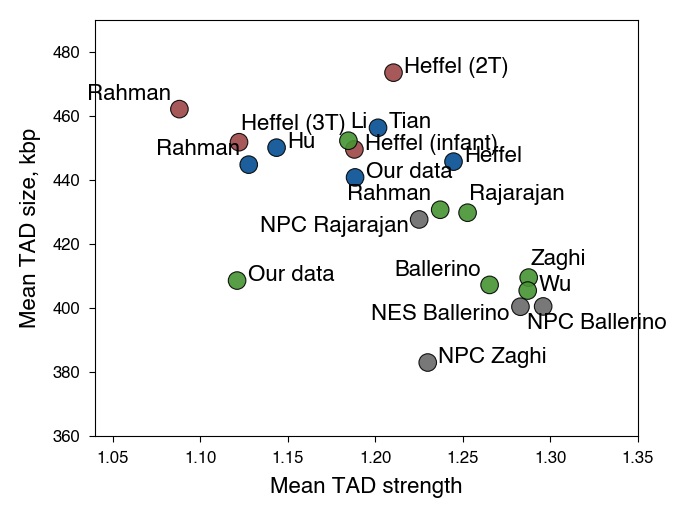

In [13]:
plt.figure(figsize=(3.5,2.7), dpi=200)

ax = plt.gca()

s = sns.scatterplot(
 domains_df, x='domain_score_mean', y='tads_sizes_mean',
 hue='Group', palette=groups_colors,  
 s=40,
 edgecolor=(0,0,0,0,), linewidth=0.4, alpha=.9
)

for i, data in domains_df.iterrows():
    x = data['domain_score_mean']
    y = data['tads_sizes_mean']
    align = 'left'
    xytext = (x+.006, y-40)
    match data.Simple_Name:
        case 'Rahman'  | 'Ballerino': #
            align = 'right'
            xytext = (x-.005, y+3000)
        case 'NPC Rajarajan' | 'NES Ballerino': 
            align = 'right'
            xytext = (x-.006, y-4000)
        case 'Heffel (3T)' | 'Li' | 'Zaghi' | 'Rajarajan':
            align = 'left'
            xytext = (x+.001, y+4000)
        case 'NPC Ballerino': 
            align = 'left'
            xytext = (x-.009, y-7000)
    plt.annotate(data.Simple_Name, 
                 xy=(x, y),  
                 xycoords='data',
                 xytext = xytext,
                 ha=align
                )

plt.gca().get_legend().remove()

s.yaxis.set_major_formatter(lambda x, pos: str(int(x/1000)))
plt.ylim(360000, 490000)
plt.xlim(1.04, 1.35)

plt.xlabel('Mean TAD strength')
plt.ylabel('Mean TAD size, kbp')
plt.savefig('./tads_visualizations/tads_size_vs_strength.pdf', bbox_inches='tight')
plt.show()

# 4. Analyse common TADs

In [14]:
domain_scores_df = pileups_df[['domain_score']].join(samples_metainfo)
domain_scores_df = domain_scores_df.explode('domain_score')

In [15]:
def get_tads_data(sample1, sample2):
    tads1 = pd.DataFrame(pileups_df.loc[sample1, 'tad_coords'])
    tads2 = pd.DataFrame(pileups_df.loc[sample2, 'tad_coords'])
    domain_scores1 = pileups_df.loc[sample1, 'domain_score']
    domain_scores2 = pileups_df.loc[sample2, 'domain_score']

    tads1['domain_score'] = domain_scores1 
    tads2['domain_score'] = domain_scores2

    backlash = 1.5 * resolution
    merged = tads1.merge(tads2, on='chrom').query(f'((start_x - {backlash} <= start_y <= start_x + {backlash}) and (end_x - {backlash} <= end_y <= end_x + {backlash}))')
    merged.columns = ['chrom', 'start_1', 'end_1', 'domain_score_1', 'start_2', 'end_2', 'domain_score_2']
    merged['start'] = merged[['start_1', 'start_2']].apply(np.min, axis=1)
    merged['end'] = merged[['end_1', 'end_2']].apply(np.max, axis=1)
    merged = merged[['chrom', 'start', 'end', 'domain_score_1', 'domain_score_2']]
    merged['lFC'] = np.log2(merged['domain_score_1'] / merged['domain_score_2'])
    return merged


def get_tads_expected_n(sample1, sample2):    
    tads1 = pd.DataFrame(pileups_df.loc[sample1, 'tad_coords'])
    tads2 = pd.DataFrame(pileups_df.loc[sample2, 'tad_coords'])
    return np.min([len(tads1), len(tads2)])

def get_tads_jaccard(sample1, sample2):
    tads1 = pd.DataFrame(pileups_df.loc[sample1, 'tad_coords'])
    tads2 = pd.DataFrame(pileups_df.loc[sample2, 'tad_coords'])
    backlash = 1.5 * resolution
    merged = tads1.merge(tads2, on='chrom').query(f'((start_x - {backlash} <= start_y <= start_x + {backlash}) and (end_x - {backlash} <= end_y <= end_x + {backlash}))')

    s1, s2, s12 = len(tads1), len(tads2), len(merged)
    return s12 / (s1 + s2 - s12)

In [16]:
%%time

samples = samples_metainfo.index.unique()
data = np.array([get_tads_data(*samp) for samp in product(samples, samples)])
tads_compare = pd.DataFrame(data.reshape(len(samples), -1), columns=samples, index=samples)

tads_expected_n = np.array([get_tads_expected_n(*tup) for tup in product(samples, samples)])
tads_expected_n = pd.DataFrame(tads_expected_n.reshape(len(samples), -1), columns=samples, index=samples)

tads_compare_counts = tads_compare.applymap(len)
tads_compare_frac = tads_compare_counts / tads_expected_n

tads_compare_corrs = tads_compare.applymap(lambda x: stats.pearsonr(x.domain_score_1, x.domain_score_2)[0])

<timed exec>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


CPU times: user 1min 28s, sys: 16.6 s, total: 1min 45s
Wall time: 1min 49s


In [17]:
data = np.array([get_tads_jaccard(*samp) for samp in product(samples, samples)])
tads_jaccard = pd.DataFrame(data.reshape(len(samples), -1), columns=samples, index=samples)

/tmp/ipykernel_3794259/1975707787.py:57: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data([0, -0.025])
/tmp/ipykernel_3794259/1975707787.py:59: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data([-0.025, 0])


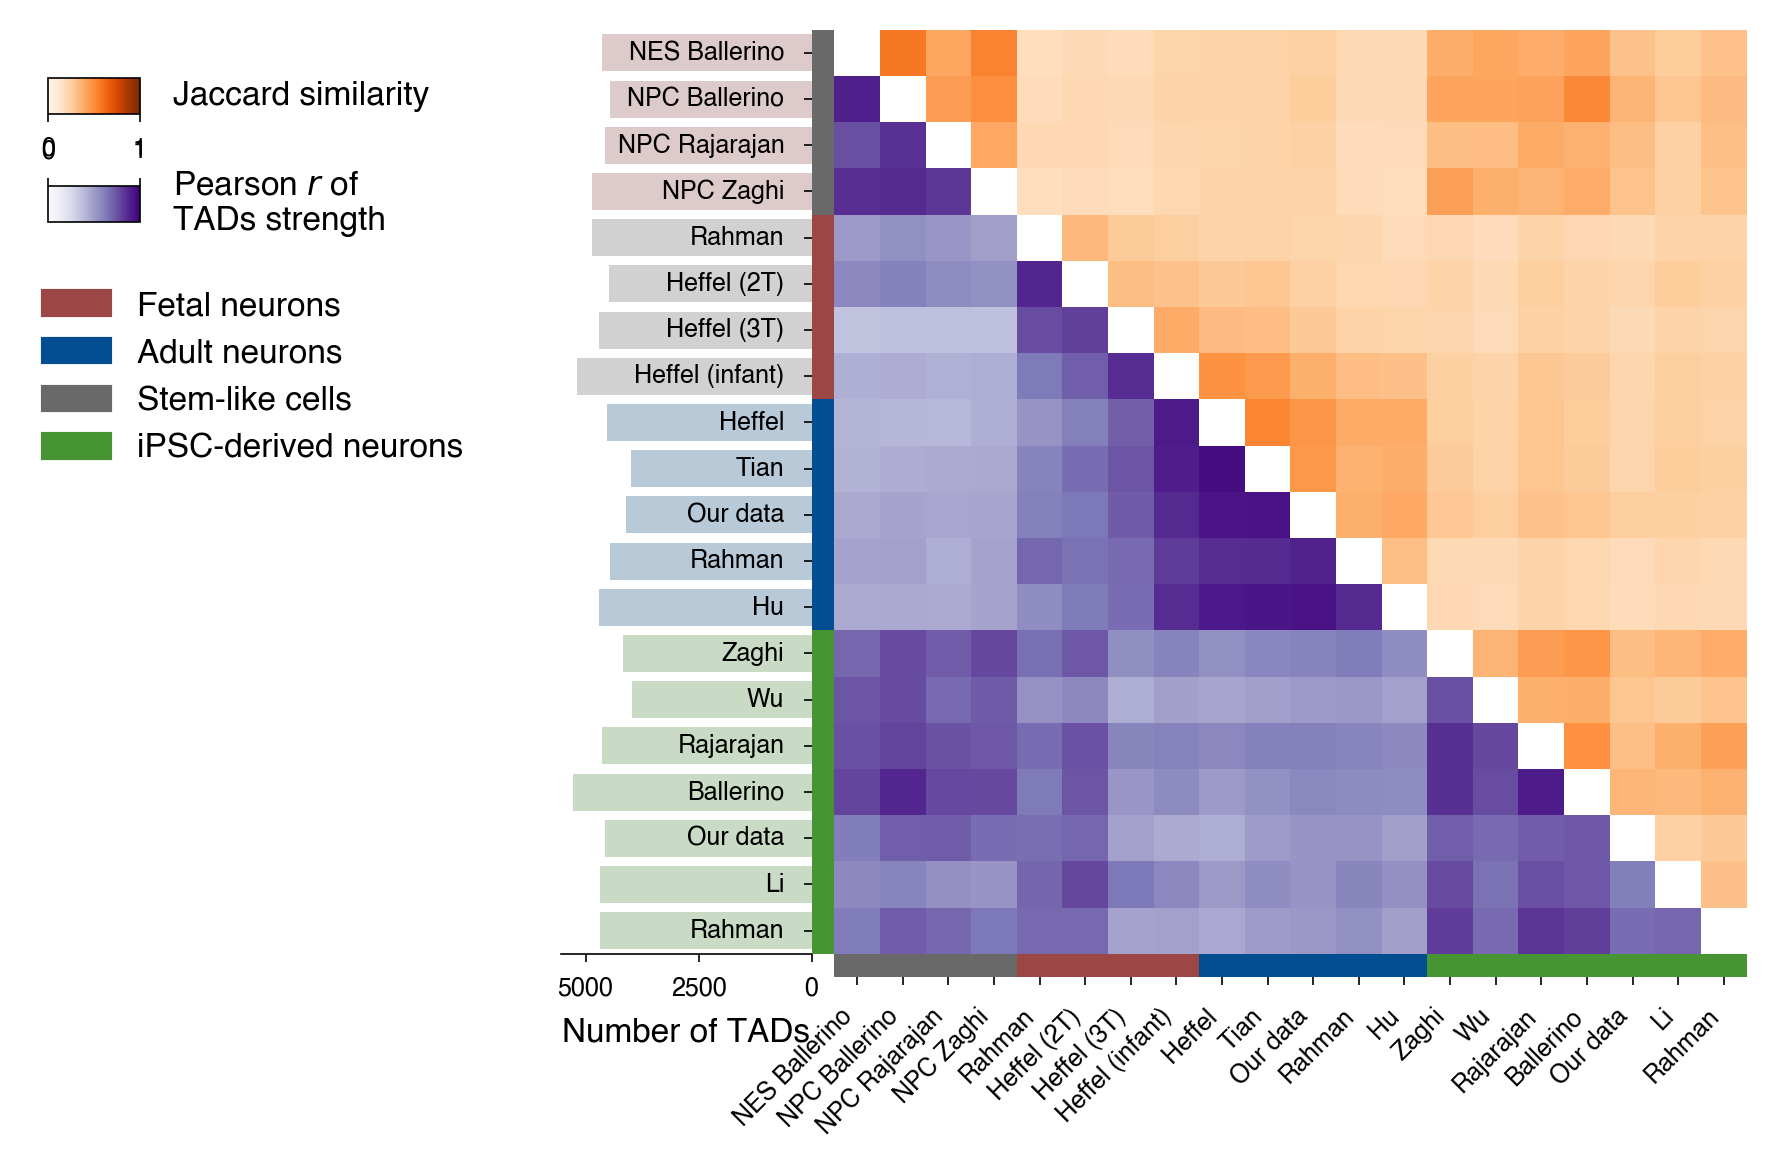

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2,
                              figsize=(5.1, 4),
                              width_ratios=(1.1, 4),
                               dpi=300
                              )

plt.subplots_adjust(wspace=0.039)

sns.barplot(domains_df, y='Short_Name', x='n_tads',
            hue='Group', palette=groups_colors, legend=False,
            alpha=0.3,
            ax = ax1)

ax1.set_ylabel(''), ax1.set_xlabel('Number of TADs')
ax1.spines[['right', 'top', 'left']].set_visible(False)
ax1.set_yticks([])
ax1.set_xticks([0, 2500, 5000])
ax1.invert_xaxis()




assert tads_compare_corrs.shape == tads_compare_frac.shape
#lower
sns.heatmap(tads_compare_corrs, 
            mask=np.triu(np.ones(shape=tads_compare_corrs.shape)),
            cmap="Purples", cbar=False,
            vmin=0.5, vmax=1,
            ax=ax2
                 )
#upper
sns.heatmap(tads_jaccard, 
            mask=np.tril(np.ones(shape=tads_jaccard.shape)),
            cmap="Oranges", cbar=False,
            vmin=0, vmax=1,
            ax=ax2,
            )
ax = ax2

## Rename labels to Simple_Names ##
ax.set_xticklabels([samples_metainfo.Simple_Name.to_dict()[l._text] for l in ax.get_xticklabels()], rotation=45, ha='right')
ax.set_yticklabels([samples_metainfo.Simple_Name.to_dict()[l._text] for l in ax.get_yticklabels()])

## Drow color boxes marking group ##
col_colors = tads_compare_corrs.columns.to_series().map(samples_metainfo.Group.to_dict()).map(groups_colors)
row_colors = tads_compare_corrs.index.to_series().map(samples_metainfo.Group.to_dict()).map(groups_colors)

for i, color in enumerate(col_colors):
    ax.add_patch(plt.Rectangle(xy=(i, -0.025), height=0.025, width=1, color=color, lw=0, transform=ax.get_xaxis_transform(), clip_on=False))
for i, color in enumerate(row_colors):
    ax.add_patch(plt.Rectangle(xy=(-0.025, i), width=0.025, height=1, color=color, lw=0, transform=ax.get_yaxis_transform(), clip_on=False))

## Shift ticks and labels (because they may intersect color boxes) ##
ax.tick_params(axis='x', pad=10)
ax.tick_params(axis='y', pad=10)
for line in ax.get_xticklines():
    line.set_data([0, -0.025])
for line in ax.get_yticklines():
    line.set_data([-0.025, 0])
        
plt.xlabel(''), plt.ylabel('')


plt.legend(handles = [mpatches.Patch(color=color, label=label) for label, color in groups_colors.items()],
           bbox_to_anchor=(-.9, 0.75), loc='upper left',
           fontsize=8,
           frameon=False)


## On-top cbars ##
cbar_x, cbar_y = -.21, 0.81
cbar_v, cbar_h = .03, .06
cax = plt.gcf().add_axes([cbar_x, cbar_y, cbar_h, cbar_v], clip_on=False)
mpl.colorbar.ColorbarBase(norm=mcolors.Normalize(vmin=0, vmax=1), cmap='Oranges', ax=cax, orientation='horizontal',
                         ticks=[0,1], label='', location='bottom')
cax.set_ylabel('Jaccard similarity', rotation=0, ha='left', va='center', fontsize=8, labelpad=-30)

cax = plt.gcf().add_axes([cbar_x, cbar_y-.09, cbar_h, cbar_v], clip_on=False)
mpl.colorbar.ColorbarBase(norm=mcolors.Normalize(vmin=0, vmax=1), cmap='Purples', ax=cax, orientation='horizontal',
                         ticks=[0,1], label='', location='top')
cax.set_ylabel('Pearson $r$ of\nTADs strength', rotation=0, ha='left', va='center', fontsize=8, labelpad=-30)

plt.savefig('./tads_visualizations/commond_tads_heatmap.pdf', bbox_inches='tight')
plt.show()

# 5. Get border and corner dot enrichment

In [19]:
def get_dot_mask(arr, w=5, p=4):
    s = p
    x,y = donut_center = (33, 66)
    mask = np.empty(arr.shape)
    mask[:] = np.nan
    mask[x-s+1:x+s+1+1, y-s-1:y+s+1-1] = np.ones((2*s+1,2*s+1))
    return mask

def get_stipe_mask(arr, w=5, p=4):
    s = p
    x,y = donut_center = (33, 66)
    mask = np.empty(arr.shape)
    mask[:] = np.nan
    mask[x-s//2:x+s//2+1, y-x+x//4-1:y-x//2+x//4+1] = np.ones((s+1, x//2+3))
    mask[y-x+x//4:y-x//2+x//4+2, x+x-s//2:x+x+s//2+1] = np.ones((s+1, x//2+3)).T
    return mask

def get_body_mask(arr):
    x,y = donut_center = (33, 66)
    mask = np.empty(arr.shape)
    mask[:] = np.nan
    trapeze = (1-np.triu(np.ones((x,x)), k=22)) * np.triu(np.ones((x,x)), k=5)
    trapeze = np.where(trapeze==0, np.nan, trapeze)
    trapeze[:4, :] = np.nan
    trapeze[:, -3:] = np.nan
    mask[x:y, x:y] = trapeze
    return mask

def get_dot_enrich(arr):
    feature_mean = np.nanmean(np.where(get_dot_mask(arr)==1, arr, np.nan))
    body_mean = np.nanmean(np.where(get_body_mask(arr)==1, arr, np.nan))
    return np.log2(feature_mean / body_mean)

def get_border_enrich(arr):
    feature_mean = np.nanmean(np.where(get_stipe_mask(arr)==1, arr, np.nan))
    body_mean = np.nanmean(np.where(get_body_mask(arr)==1, arr, np.nan))
    return np.log2(feature_mean / body_mean)

def preprocess_props(data, idx):
    df_props = pd.DataFrame({'border_enrich': data.border_enrich > 0,
                             'dot_enrich': data.dot_enrich > 0}
                           ).value_counts(normalize=True).to_frame().reset_index()
    df_props.index = [idx]*4
    df_props.proportion = df_props.proportion * 100
    for col in ['border_enrich', 'dot_enrich']:
        name = col.split('_')[0].capitalize()
        df_props[col] = df_props[col].astype('category').cat\
                                     .rename_categories({True: name+'>0', False: name+'<0'})\
                                     .astype('str')
    df_props['enrich'] = df_props['dot_enrich'] + ', ' + df_props['border_enrich']
    df_props = df_props[['enrich','proportion']].set_index('enrich').T
    return df_props.iloc[0] 

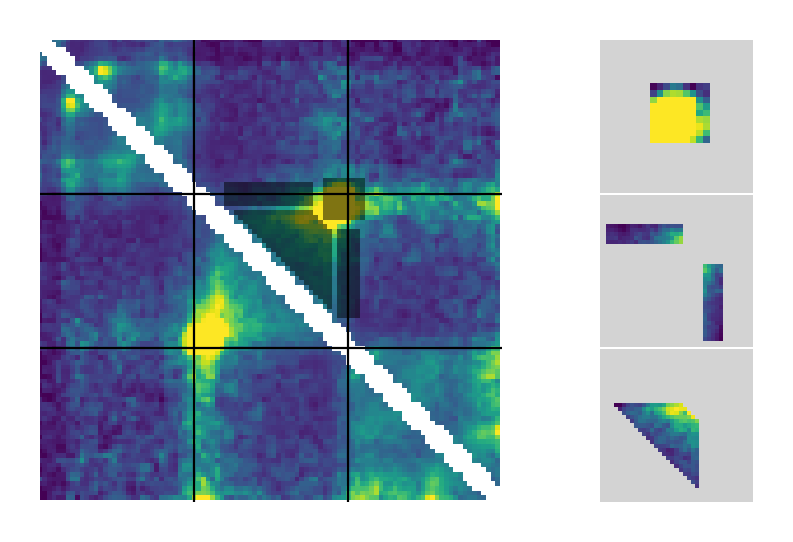

In [20]:
plt.figure(figsize=(2.5,1.5), dpi=400)
grid = plt.GridSpec(nrows=3, ncols=2, 
                    hspace=.01, wspace=.1,
                    width_ratios=[3, 1])

arr = pileups_df.iloc[0].loc['domains_data'][11]
cmap = cm.viridis
cmap.set_bad('lightgrey',1)

ax = plt.subplot(grid[2,1])
ax.imshow(np.where(get_body_mask(arr)==1, arr, np.nan),vmax=3, cmap=cmap)
ax.set_ylim(66-5, 33-10), ax.set_xlim(33+5, 66+10)
ax.set_axis_off()

ax = plt.subplot(grid[1,1])
ax.imshow(np.where(get_stipe_mask(arr)==1, arr, np.nan),vmax=3, cmap=cmap)
ax.set_ylim(66-5, 33-10), ax.set_xlim(33+5, 66+10)
ax.set_axis_off()

ax = plt.subplot(grid[0,1])
arrr = np.where(get_dot_mask(arr)==1, arr, np.nan)
ax.imshow(arrr, vmax=3, cmap=cmap)
ax.set_ylim(66-20, 33-10), ax.set_xlim(33+20, 66+10)
ax.set_axis_off()

a = .5
lower_ax = plt.subplot(grid[:,0])
lower_ax.imshow(arr,vmax=3)
lower_ax.imshow(get_body_mask(arr), vmax=1,cmap='Greys_r', alpha=a)
lower_ax.imshow(get_dot_mask(arr), vmax=1,cmap='Greys_r', alpha=a)
lower_ax.imshow(get_stipe_mask(arr), vmax=1,cmap='Greys_r', alpha=a)

ps = [33, 66]
lower_ax.vlines(ps, 0, 99, color='k', clip_on=True, linewidth=0.4)
lower_ax.hlines(ps, 0, 99, color='k', clip_on=True, linewidth=0.4)
lower_ax.set_ylim(99,0)
lower_ax.set_xlim(0,99)
lower_ax.set_axis_off()

plt.show()

In [21]:
%%time

pileups_df['dot_enrich'] =  pileups_df.domains_data.apply(lambda tads: [get_dot_enrich(tad) for tad in tads])
pileups_df['border_enrich'] =  pileups_df.domains_data.apply(lambda tads: [get_border_enrich(tad) for tad in tads])

CPU times: user 1min 3s, sys: 2.13 s, total: 1min 5s
Wall time: 1min 4s


In [22]:
scatters_data = {}
for idx, data in pileups_df.iterrows():
    df = pd.DataFrame([data.dot_enrich, data.border_enrich, data.tads_sizes],
                      index=['dot_enrich', 'border_enrich', 'tads_sizes']).T
    scatters_data[idx] = df    

cols = ['Dot>0, Border<0', 'Dot<0, Border<0', 'Dot>0, Border>0','Dot<0, Border>0']
props = pd.DataFrame(columns = cols)
for idx, data  in scatters_data.items():
    props.loc[idx] = preprocess_props(data, idx)

In [23]:
props_df = props.join(samples_metainfo)
props_df['Border>0']  = props_df['Dot>0, Border>0'] + props_df['Dot<0, Border>0']

props_df_long = props_df.copy()
props_df_long.columns = ['D', 'N', 'DB', 'B', 'Group', 'Short_Name', 'Simple_Name', 'Restriction_enzyme', 'Sample_Name', 'BB']
props_df_long.columns = ['X' + c if len(c) <=2 else c for c in props_df_long.columns]
props_df_long = props_df_long.drop(columns=['XBB'])

props_df_long = pd.wide_to_long(props_df_long.reset_index(), stubnames='X', j='TAD_type', i='index', suffix='.*')
props_df_long = props_df_long.reset_index('TAD_type')
props_df_long['Group'] = props_df_long['Group'].astype('str')

In [24]:
results = None
for tad_type, data in props_df_long.groupby('TAD_type'):
    data.query('Group=="iPSC-derived neurons"')['X']

    res = pg.mwu(data.query('Group=="iPSC-derived neurons"')['X'], 
                data.query('Group=="Adult neurons"')['X'])
    res.index = [tad_type]
    if results is None:
        results = res
    else:
        results = pd.concat([results, res])

In [25]:
results['p_adj'] = pg.multicomp(results['p-val'])[1]
results['signif'] = pg.multicomp(results['p-val'])[0]

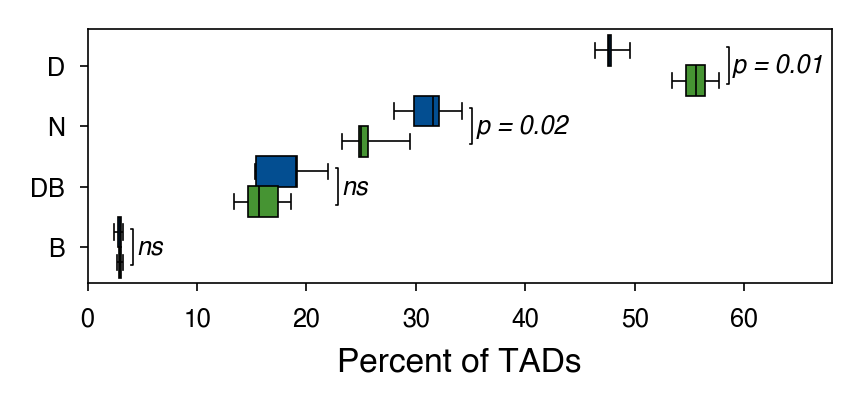

In [26]:
plt.figure(figsize=(3.2, 1.1), dpi=300)
ax = sns.boxplot(props_df_long.query('Group=="Adult neurons" or Group=="iPSC-derived neurons"').astype(str).astype({'X':float}),
            x='X', y='TAD_type', 
            linewidth=0.4, linecolor='k',
            width=1, gap=-.02, whis=10,
               hue='Group', palette=groups_colors, saturation=1,)



plt.ylim((3.6, -.6)), plt.xlim(0, 68)
plt.ylabel(''), plt.xlabel('Percent of TADs')

for t in ax.get_yticklabels():
    x = props_df_long.groupby('TAD_type')['X'].max().loc[t.get_text()] + 1.2
    if results.loc[t.get_text(), 'signif']:
        text = f'p = {results.loc[t.get_text(), "p_adj"]:.2f}'
    else: 
        text = 'ns'
    plt.plot([x-.5, x-.3, x-.3, x-.5], [t._y-.3, t._y-.3, t._y+.3, t._y+.3], c='k', lw=.4)
    ax.text(x, t._y, text,
           fontsize=6,va='center', fontstyle='italic')

plt.gca().get_legend().remove()
plt.savefig('./tads_visualizations/tads_border_and_dot_enrichment.pdf', bbox_inches='tight')
plt.show()

# 6. Plot an example

In [27]:
%%time
gff_colnames = ('chrom', 'DB', 'type', 'start', 'end', '_', 'strand', '__', 'data')
annotation = pd.read_csv('https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_44/gencode.v44.annotation.gff3.gz', sep='\t', header=None, comment='#', names=gff_colnames)
annotation['gene_name'] = annotation['data'].str.extract(r'gene_name=([^;]+)', expand=False)
annotation['gene_type'] = annotation['data'].str.extract(r'gene_type=([^;]+)', expand=False)
annotation['gene_id'] = annotation['data'].str.extract(r'gene_id=([^;]+)', expand=False)
annotation = annotation[['chrom', 'start', 'end', 'gene_name', 'gene_type', 'strand', 'type', 'gene_id']]
annotation = annotation.query('type=="gene"')
annotation = annotation.sort_values(by=['chrom', 'start', 'end', 'gene_name'], ascending=True)
annotation = annotation.dropna(subset=['chrom', 'start', 'end'])
annotation.start = annotation.start.astype(np.int64)
annotation.end = annotation.end.astype(np.int64)
annotation['tss'] = annotation.apply(lambda x: x['start'] if x['strand'] == "+" else x['end'], axis=1)

genes_tss = annotation[['chrom', 'tss', 'gene_name', 'gene_id', 'start', 'end']]
genes_tss = genes_tss.drop_duplicates()
genes_tss = genes_tss.query('not (gene_name.str.startswith("ENSG") or gene_name.str.startswith("LINC") or gene_name.str.startswith("RN7S") )')

CPU times: user 31.5 s, sys: 3.1 s, total: 34.6 s
Wall time: 1min 48s


In [28]:
def merge_tads(tads1, tads2):
    factor = 1.5
    sy = f'(start_x - {factor*binsize} <= start_y <= start_x + {factor*binsize})'
    ey = f'(end_x - {factor*binsize} <= end_y <= end_x + {factor*binsize})'
    tads1 = tads1.merge(tads2, on='chrom').query(f'{sy} and {ey}')
    tads1['start'] = (tads1['start_x'] + tads1['start_y'])//2
    tads1['end'] = (tads1['end_x'] + tads1['end_y'])//2
    #common_tads = common_tads[['chrom', 'start', 'end']]
    tads1 = tads1.drop(columns=['start_x', 'end_x', 'start_y', 'end_y'])
    return tads1

def get_common_tads(pileups_df):
    common_tads = pd.DataFrame(columns=['chrom', 'start', 'end'])
    
    for i, (idx, row) in enumerate(pileups_df.iterrows()):
        print(i, row.Short_Name, end=': ') 
        tad_coords = pd.DataFrame(row.tad_coords)
        tad_coords['domain_score--'+str(row.Short_Name)] = row.domain_score
        #tad_coords['dot_enrich--'+str(row.Short_Name)] = row.dot_enrich
        if i == 0:
            common_tads = tad_coords
        else:
            common_tads = merge_tads(common_tads, tad_coords)
        print(len(common_tads))
    return common_tads

def get_tad(sample, tad):
    tad_coords = pd.DataFrame(sample.tad_coords).astype({'chrom': str, 'start': int, 'end': int})
    tad = tad.astype({'chrom': str, 'start': int, 'end': int})
    closest_tads = bf.closest(tad, tad_coords, suffixes=('_', ''), k=5,
                             ignore_overlaps=False, ignore_upstream=True, ignore_downstream=True,
                             )[['chrom', 'start', 'end']]
    i_tad = closest_tads[['start', 'end']].sub(tad[['start', 'end']].iloc[0]).sum(axis=1).abs().nsmallest(1).index[0]
    tad_in_sample = closest_tads.iloc[i_tad].to_dict()
    tad_index = sample.tad_coords.index(tad_in_sample)
    return sample.domains_data[tad_index]

In [29]:
common_tads = get_common_tads(pileups_df)

0 NES Ballerino: 4866
1 NPC Ballerino: 3398
2 NPC Rajarajan: 2441
3 NPC Zaghi: 2172
4 Fetal neurons Rahman: 1006
5 Fetal neurons Heffel (2T): 783
6 Fetal neurons Heffel (3T): 617
7 Fetal neurons Heffel (infant): 557
8 Neurons Heffel: 519
9 Neurons Tian: 486
10 Neurons Pletenev: 436
11 Neurons Rahman: 359
12 Neurons Hu: 266
13 iPSC-derived neurons Zaghi: 245
14 iPSC-derived neurons Wu: 230
15 iPSC-derived neurons Rajarajan: 225
16 iPSC-derived neurons Ballerino: 222
17 iPSC-derived neurons Lagarkova: 197
18 iPSC-derived neurons Li: 172
19 iPSC-derived neurons Rahman: 163


In [30]:
common_tads = common_tads.set_index(['chrom', 'start', 'end']).melt(var_name='Short_Name', value_name='domain_score', ignore_index=False)
common_tads['Short_Name'] = common_tads.Short_Name.str.split('--').str[1]

In [31]:
regions = [
            ('chr2',	170392500,	170932500),
            ('chr6', 98836453, 99262500),
            ('chr7',	82027500, 82762500),
          ]
regions_df = pd.DataFrame(regions, columns=['chrom', 'start', 'end'])

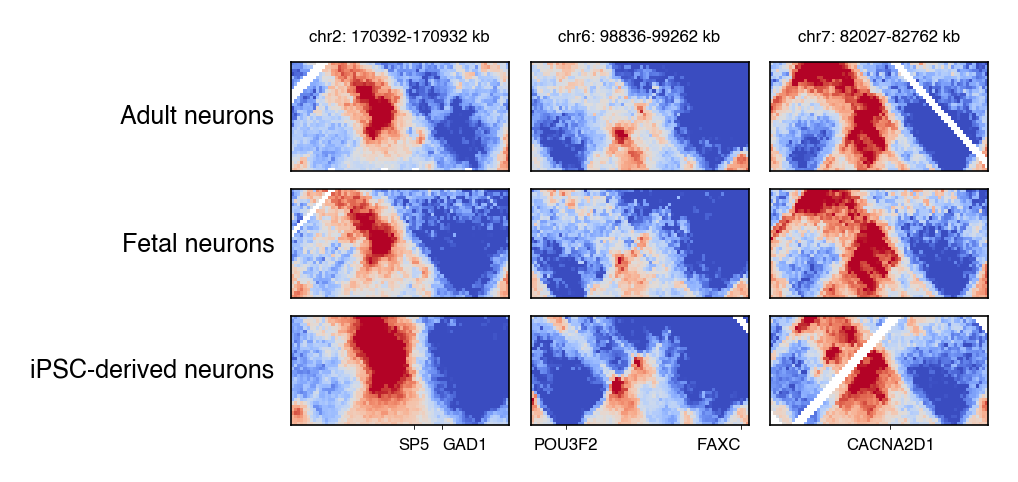

In [32]:
fig, axss  = plt.subplots(nrows=3, 
                          ncols=3, figsize=(3, 1.6), dpi=300,)
axss = axss.T
norm = LogNorm(vmin=0.5, vmax=2)

for axs, (i, region) in zip(axss, regions_df.iterrows()):
    super_tad_imgs = pileups_df.set_index('Sample_Name').apply(lambda x: get_tad(x, region.to_frame().T), axis=1)
    r_chrom, r_start, r_end = region.chrom, region.start, region.end

    yy = samples_metainfo.astype({'Group':'str'}).query('Group!="Stem-like cells"').groupby('Group').Sample_Name.agg(list)
    for j, (group, ss) in enumerate(yy.items()):
        ax = axs[j]
        img = np.array([super_tad_imgs[s] for s in ss]).mean(axis=0)
        img[np.isnan(img)] = 0
        img = rotate(img, angle=45, reshape=True, order=0)
        img = img[img.shape[1]//4 : img.shape[0]//2 - 3, :]
        img = img[:, img.shape[1]//4 : img.shape[1]*3//4 ]

        ax.imshow(img,
                  cmap='coolwarm', aspect="auto",
                  norm = norm, interpolation="none",
                 )
        
        ax.set_box_aspect(0.5)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.label_outer()

        if i == 0:
            ax.set_ylabel(group, rotation=0, ha='right', va='center', fontsize=6)

        if j == 0:
             ax.set_title(f'{r_chrom}: {r_start//1e3:.0f}-{r_end//1e3:.0f} kb',
                          ha='center', va='center', fontsize=4)           
        
    g_ax = axss[i, 2]
    r_len = r_end-r_start
    r_start, r_end = r_start-r_len, r_end+r_len
    r_len = r_end-r_start
    gr_start, gr_end = r_start + r_len//4, r_end - r_len//4

    interesting_genes = ['GAD1', 'SP5',
                         'POU3F2', 'FAXC',
                         'CACNA2D1', 
                         
    ]
    r_genes = genes_tss.query('chrom==@r_chrom and tss>@gr_start and tss<@gr_end').sort_values(by='tss').query('gene_name.isin(@interesting_genes)')

    i = 0
    for g, (tss, gs, ge) in r_genes.set_index('gene_name')[['tss', 'start', 'end']].iterrows():
        i+=1
        x = ((tss - gr_start) * 70 )// (gr_end - gr_start)
        gs = ((gs - gr_start) * 70 )// (gr_end - gr_start)
        ge = ((ge - gr_start) * 70 )// (gr_end - gr_start)
        
        arrowprops = dict(
            arrowstyle="-", lw=.2,
            connectionstyle="angle,angleA=0,angleB=90,rad=4")  
        match g:
            case 'GAD1':
                ha = 'left'
            case 'FAXC':
                ha = 'right'
            case _:
                ha = 'center'
        g_ax.annotate(g,
                    xy=(x, 0), # gs+(ge-gs)/2
                    xycoords=g_ax.get_xaxis_transform(),
                    xytext=(x, -.22-i*0/7), 
                    textcoords=g_ax.get_xaxis_transform(),
                    arrowprops=arrowprops,
                    ha=ha,fontsize=4,)
    plt.subplots_adjust(wspace=.1, hspace=.1)

plt.savefig('./tads_visualizations/tads_example.pdf', bbox_inches='tight')
plt.show()